# Summary

Validate a trained neural network.

# Imports

In [1]:
%run _imports.ipynb

Setting the PACKAGE_VERSION environment variable.
Setting the DOCS_SECRET_KEY environment variable.
Setting the PYTHON_VERSION environment variable.
Setting the SPARK_MASTER environment variable.
Setting the SPARK_ARGS environment variable.
Setting the DB_TYPE environment variable.
Setting the DB_PORT environment variable.


2018-02-09 18:37:17.694147


In [2]:
import torch

from sklearn import metrics


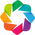

In [3]:
import holoviews as hv
hv.extension('bokeh','matplotlib')

In [4]:
import pagnn
pagnn.CUDA = False

# Parameters

In [5]:
NOTEBOOK_NAME = 'analyze_trained_network'
os.makedirs(NOTEBOOK_NAME, exist_ok=True)

In [6]:
DATA_PATH = Path.cwd().absolute()

In [7]:
MODELS_PATH = Path('train_neural_network/train_nn_3-permute-seq-0-9f2f3c506cfc5f7f56c2e292604f7925/models')

# Load data

## `models_df`

In [8]:
model_files = os.listdir(MODELS_PATH)

In [9]:
models_df = pd.DataFrame(model_files, columns=['model_file'])

display(models_df.head(2))
print(len(models_df))

,model_file
0,step-7802880.model
1,step-6737920.model


776


In [10]:
models_df['step'] = models_df['model_file'].str.extract('step-(\d*).model', expand=True).astype(int)

In [11]:
display(models_df.head(2))
print(len(models_df))

,model_file,step
0,step-7802880.model,7802880
1,step-6737920.model,6737920


776


In [12]:
models_df = models_df.sort_values('step')

In [13]:
models_df.tail()

,model_file,step
109,step-7895040.model,7895040
241,step-7905280.model,7905280
75,step-7915520.model,7915520
518,step-7925760.model,7925760
455,step-7936000.model,7936000


# Functions

# Load network

In [14]:
net = pagnn.models.ModernNet(12)

In [15]:
net.load_state_dict(
    torch.load(
        MODELS_PATH.joinpath('step-7936000.model'),
        map_location=lambda storage, loc: storage)
)

In [16]:
protherm_datagen = pagnn.get_mutation_datagen('protherm', DATA_PATH)

In [17]:
targets, outputs = pagnn.evaluate_mutation_dataset(net, protherm_datagen)

In [18]:
data = OrderedDict([
    ('ddg_exp', targets.squeeze()),
    ('ddg_pred', -outputs.squeeze()),
    ('mutation', [ds[0][0].meta['mutation'] for ds in protherm_datagen()]),
])

protherm_df = pd.DataFrame(data)

Text(0,0.5,'Number of mutations')

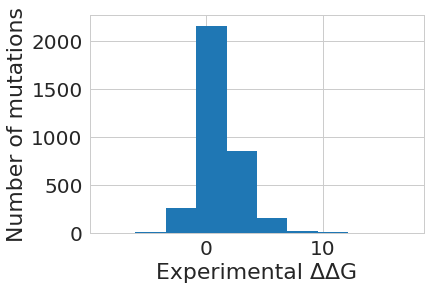

In [19]:
plt.hist(protherm_df['ddg_exp'])
plt.xlabel('Experimental ΔΔG')
plt.ylabel('Number of mutations')

In [20]:
metrics.roc_auc_score((protherm_df['ddg_exp'] > 5).astype(int), protherm_df['ddg_pred'])

0.66778946105869186

# Analysis

## Exp. vs pred. ΔΔG values

In [21]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool

source = ColumnDataSource(protherm_df)

output_file(f"{NOTEBOOK_NAME}/ddg_pred_vs_exp.html")

hover = HoverTool(tooltips=[
    ("index", "$index"),
    ("ΔΔG exp", "@ddg_exp"),
    ("ΔΔG pred", "@ddg_pred"),
    ("Mutation", "@mutation"),
])

spearman_corr = sp.stats.spearmanr(protherm_df['ddg_exp'].values, protherm_df['ddg_pred'].values)

p = figure(
    plot_width=600,
    plot_height=400,
    tools=[hover,'wheel_zoom', 'box_zoom', 'reset', 'save', 'pan'],
    title=f"Spearman R: {spearman_corr[0]:.3f} (p-value: {spearman_corr[1]:.2e})")

p.circle('ddg_exp', 'ddg_pred', size=4, source=source)

# show(p)

Session output file 'analyze_trained_network/ddg_pred_vs_exp.html' already exists, will be overwritten.


GlyphRenderer(id='cf19ffea-4fc7-48f5-996d-0e9e9a37538d', ...)

## Convolutions

In [22]:
df = pd.DataFrame(net.spatial_conv.weight[0].data.numpy(), columns=[0, 1], index=pagnn.AMINO_ACIDS)
df.head()

,0,1
G,0.540019,0.220917
V,-0.013141,-0.194089
A,-0.000794,-0.406903
L,-0.041672,-0.430928
I,-0.030040,-0.321018


In [23]:
df2 = df.reset_index().melt(id_vars=['index'], value_vars=[0, 1]).head()
df2.head()

,index,variable,value
0,G,0,0.540019
1,V,0,-0.013141
2,A,0,-0.000794
3,L,0,-0.041672
4,I,0,-0.030040


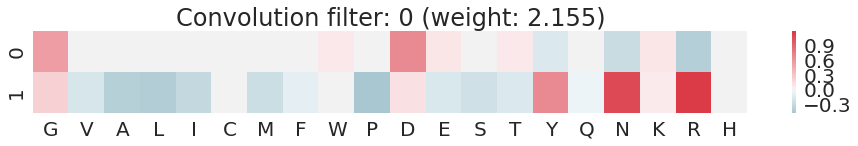

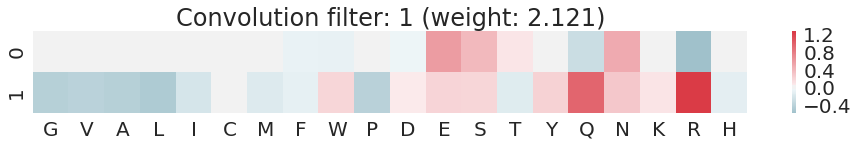

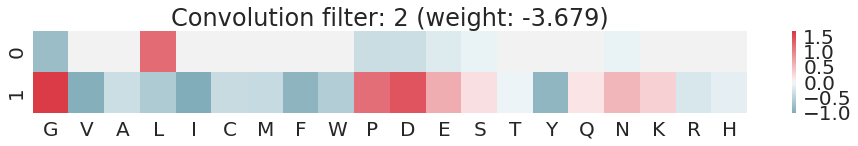

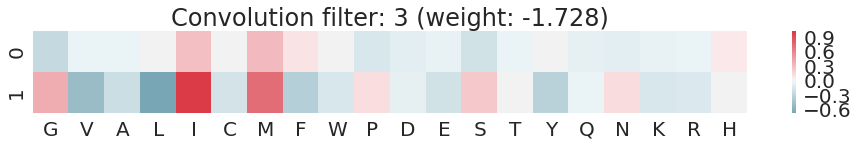

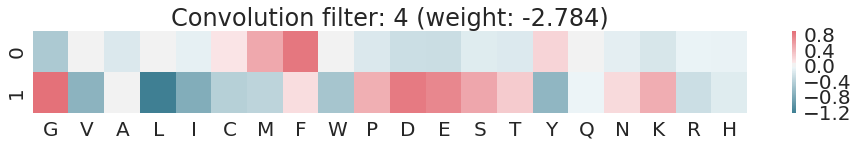

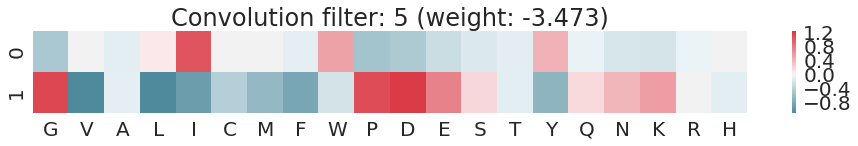

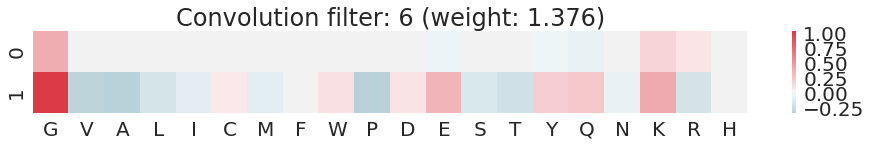

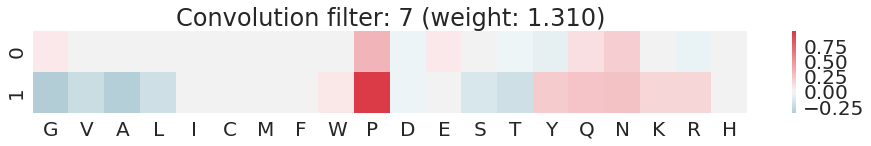

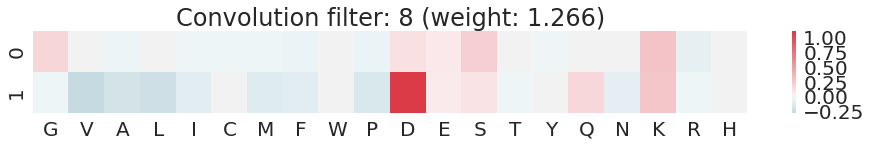

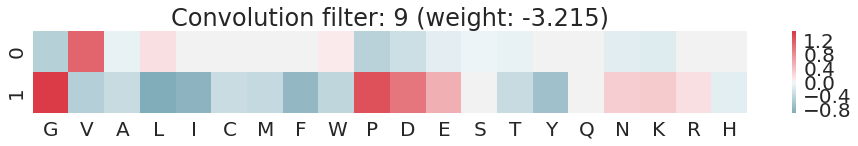

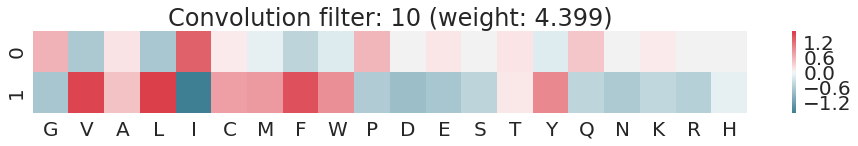

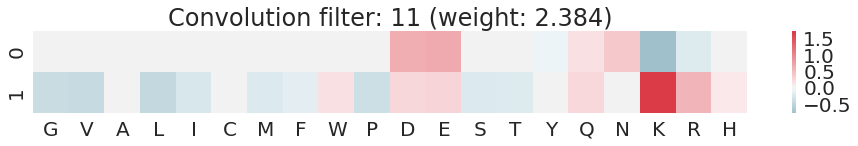

In [24]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# cmap = sns.color_palette("Blues")

for i in range(12):
    fg, axs = plt.subplots(figsize=(16, 1.5))

    sns.heatmap(
        net.spatial_conv.weight[i].data.numpy().T,
        xticklabels=pagnn.AMINO_ACIDS,
        yticklabels=[0, 1],
        cmap=cmap,
        center=0)

    plt.title(f"Convolution filter: {i} (weight: {net.combine_weights.weight.data.squeeze()[i]:.3f})")
    plt.show()

## Alpha-helical domains

In [25]:
alpha_helical_domains = list(
    DATA_PATH
    .joinpath('threshold_by_pc_identity')
    .joinpath('adjacency_matrix_validation_gt80.parquet')
    .glob('database_id=G3DSA%3A1.*')
)

In [26]:
alpha_helical_domains[:5]

[PosixPath('/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/threshold_by_pc_identity/adjacency_matrix_validation_gt80.parquet/database_id=G3DSA%3A1.20.1440.60'),
 PosixPath('/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/threshold_by_pc_identity/adjacency_matrix_validation_gt80.parquet/database_id=G3DSA%3A1.10.246.60'),
 PosixPath('/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/threshold_by_pc_identity/adjacency_matrix_validation_gt80.parquet/database_id=G3DSA%3A1.10.3610.10'),
 PosixPath('/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/threshold_by_pc_identity/adjacency_matrix_validation_gt80.parquet/database_id=G3DSA%3A1.10.10.600'),
 PosixPath('/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/threshold_by_pc_identity/adjacency_matrix_validation_gt80.parquet/database_id=G3DSA%3A1.10.1200.30')]

In [27]:
alpha_helical_domain_weights_file = Path(NOTEBOOK_NAME).joinpath('alpha_helical_domain_weights.pickle')

try:
    with alpha_helical_domain_weights_file.open('rb') as fin:
        alpha_helical_domain_weights = np.array(pickle.load(fin))
except FileNotFoundError:
    alpha_helical_domain_weights = pagnn.get_weights(alpha_helical_domains)
    with alpha_helical_domain_weights_file.open('wb') as fout:
        pickle.dump(alpha_helical_domain_weights.tolist(), fout, pickle.HIGHEST_PROTOCOL)

In [55]:
alpha_helical_rowgen = pagnn.iter_dataset_rows(
    alpha_helical_domains,
    alpha_helical_domain_weights,
    columns={
        'qseq': 'sequence',
        'residue_idx_1_corrected': 'adjacency_idx_1',
        'residue_idx_2_corrected': 'adjacency_idx_2',
    },
    random_state=np.random.RandomState(43),
)

In [56]:
print('hello')

hello


In [57]:
alpha_helical_dataset = list(
    tqdm.tqdm_notebook(
        itertools.islice(
            (pagnn.row_to_dataset(row, target=1) 
             for row
             in alpha_helical_rowgen
             if (50 < len(row.sequence.replace('-', '')) <= 500)),
            10_000
        ),
        total=10_000
    ))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

In [ ]:
alpha_helical_dataset_file = Path(NOTEBOOK_NAME).joinpath('alpha_helical_dataset.pickle')

with alpha_helical_dataset_file.open('wb') as fout:
    pickle.dump(alpha_helical_dataset, fout, pickle.HIGHEST_PROTOCOL)

(array([  0.00000000e+00,   5.28400000e+03,   2.78100000e+03,
          7.66000000e+02,   4.79000000e+02,   5.78000000e+02,
          9.30000000e+01,   2.00000000e+00,   1.50000000e+01,
          2.00000000e+00]),
 array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
         450.,  500.]),
 <a list of 10 Patch objects>)

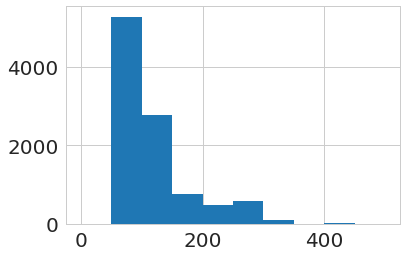

In [60]:
plt.hist([len(ds.seq) for ds in alpha_helical_dataset], range=(0, 500))

In [61]:
def shift_sequence(ds, offset):
    return ds._replace(seq=ds.seq[offset:] + ds.seq[:offset])

In [77]:
outputs = {}

for offset in tqdm.tqdm_notebook(range(32), total=32):
    outputs_list = []
    for ds in tqdm.tqdm_notebook(
            alpha_helical_dataset,
            total=len(alpha_helical_dataset),
            desc=f'Offset: {offset}',
            leave=False):
        shifted_ds = shift_sequence(ds, offset=offset)
        output = net(([pagnn.dataset_to_datavar(shifted_ds)], []))
        outputs_list.append(output)
    outputs[offset] = torch.cat(outputs_list).data.numpy().squeeze()

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 0', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 1', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 2', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 3', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 4', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 5', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 6', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 7', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 8', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 9', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 10', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 11', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 12', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 13', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 14', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 15', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 16', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 17', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 18', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 19', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 20', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 21', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 22', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 23', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 24', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 25', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 26', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 27', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 28', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 29', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 30', max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Offset: 31', max=10000), HTML(value='')))

/home/kimlab1/strokach/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


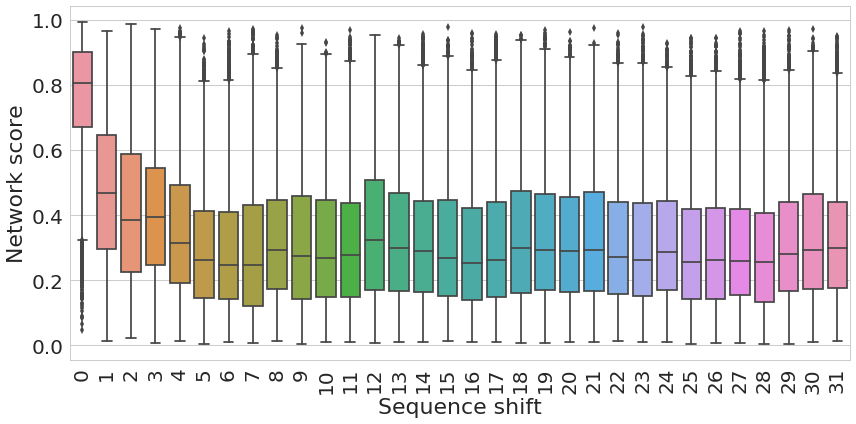

In [96]:
# Data
df = pd.DataFrame(outputs)
df = df.melt(value_vars=df.columns.tolist())
df.head()

# Plot
fg, ax = plt.subplots(figsize=(12, 6))
ax = sns.boxplot(x='variable', y="value", data=df, ax=ax)
# ax = sns.swarmplot(x="sequence_length_bin", y="value", data=df, color=".25")

# Adjust plot
plt.xticks(rotation='vertical')
plt.xlabel('Sequence shift')
plt.ylabel('Network score')

plt.tight_layout()

## Explore false +ives and false -ives

In [21]:
validation_exact_cache_file = (
    DATA_PATH
    .joinpath('train_neural_network')
    .joinpath('validation_exact_80_10000.pickle')
)    

In [22]:
with validation_exact_cache_file.open('rb') as fin:
    validation_exact_data = pickle.load(fin)

### Generate predictions table

In [23]:
len(validation_exact_data)

10000

In [24]:
validation_exact_data[:2]

[([DataSet(seq=b'PTPKTELVQKFHVQYLGMLPVDRPVGMDTLNSAIENLMTSSSKEDWPSVNMNVADATVTVISEKNEEEVLVECRVRFLSFMGVGKDVHTFAFIMDTGNQRFECHVFWCEPNAANVSEAVQAAC', adj=<123x123 sparse matrix of type '<class 'numpy.int16'>'
	with 1061 stored elements in COOrdinate format>, target=1, meta=None)],
  [DataSet(seq=b'NKLAQKYDLQRELELRQWIEEATGKRIGDNFMECLKDGVILCELINKLQPGSVRKVNESTQNWHQLENIGNFIKAITRYGVKPHDIFEANDLFENTNHTQVQSTLIALASMAKTKGNRVNVGV', adj=<123x123 sparse matrix of type '<class 'numpy.int16'>'
	with 1165 stored elements in COOrdinate format>, target=0, meta=None)]),
 ([DataSet(seq=b'RAITHLGGKATAIFPAGGATGEHLVALLADEQVAVDTVDAKDWTRQNLHVHVESSGEQYRFVMPGARLSDDEFRQLEEKVLTIESGSLLVISGSLPPGVKTEKLTALVDAVLQRGIRCIVDSSGEALQAALEPGQLELVKPNQKELSALVNRELSQPDDVRTAAEELVRSGKAHRVVVSLGPQGALAVDKTGFVQVVPPPMKSQSTVGAGDSMVGAMALKLAQGASLLEMTRYGVAAGSAATINQGTRLCSLADTQKIVDYLS', adj=<263x263 sparse matrix of type '<class 'numpy.int16'>'
	with 1883 stored elements in COOrdinate format>, target=1, meta=None)],
  [DataSet(seq=b'NALLLLADDGGFESGAY

In [26]:
outputs_pos = []
outputs_neg = []

for dsc in tqdm.tqdm_notebook(validation_exact_data, total=len(validation_exact_data)):
    ds_pos, ds_neg = dsc
    output_pos = net(pagnn.push_dataset_collection((ds_pos, []))[0])
    outputs_pos.append(output_pos)
    output_neg = net(pagnn.push_dataset_collection(([ds_neg[0]._replace(adj=ds_pos[0].adj)], []))[0])
    outputs_neg.append(output_neg)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

In [27]:
data = OrderedDict([
    ('output_pos', torch.cat(outputs_pos).data.numpy().squeeze()),
    ('output_neg', torch.cat(outputs_neg).data.numpy().squeeze()),
])

validation_exact_df = pd.DataFrame(data)

In [28]:
validation_exact_df.head()

,output_pos,output_neg
0,0.852263,0.176918
1,0.803122,0.097900
2,0.821075,0.427393
3,0.907894,0.248466
4,0.819187,0.625873


In [31]:
validation_exact_df_file = Path(NOTEBOOK_NAME).joinpath('validation_exact_df.parquet')

pq.write_table(
    pa.Table.from_pandas(validation_exact_df, preserve_index=False),
    validation_exact_df_file.as_posix(),
    version='2.0',
    flavor='spark'
)

### Add more features

In [32]:
validation_exact_df['sequence_length'] = [
    len(dsc[0][0].seq)
    for dsc in validation_exact_data
]

In [33]:
def get_num_interactions(adj, offset=0):
    keep_idx = np.abs(adj.row - adj.col) >= offset
    return np.sum(keep_idx)

In [34]:
for offset in range(10):
    validation_exact_df[f'num_interactions_pos_{offset}'] = [
        get_num_interactions(dsc[0][0].adj, offset=offset)
        for dsc in validation_exact_data
    ]
    validation_exact_df[f'num_interactions_neg_{offset}'] = [
        get_num_interactions(dsc[1][0].adj, offset=offset)
        for dsc in validation_exact_data
    ]

In [166]:
def get_frac_interactions(adj, offset=0):
    keep_idx = np.abs(adj.row - adj.col) >= offset
    return np.sum(keep_idx) / adj.shape[0]

In [167]:
for offset in range(10):
    validation_exact_df[f'frac_interactions_pos_{offset}'] = [
        get_frac_interactions(dsc[0][0].adj, offset=offset)
        for dsc in validation_exact_data
    ]
    validation_exact_df[f'frac_interactions_neg_{offset}'] = [
        get_frac_interactions(dsc[1][0].adj, offset=offset)
        for dsc in validation_exact_data
    ]

### Plot correlations

In [168]:
validation_exact_df['sequence_length_bin'] = (
    (validation_exact_df['sequence_length'] // 50 * 50).astype(int)
)

In [169]:
for i in range(10):
    validation_exact_df[f'frac_interactions_pos_{i}_bin'] = (
        (validation_exact_df[f'frac_interactions_pos_{i}'] // 1).astype(int)
    )
    validation_exact_df[f'frac_interactions_neg_{i}_bin'] = (
        (validation_exact_df[f'frac_interactions_neg_{i}'] // 1).astype(int)
    )

In [170]:
validation_exact_df.head()

,output_pos,output_neg,sequence_length,num_interactions_pos_0,num_interactions_neg_0,num_interactions_pos_1,num_interactions_neg_1,num_interactions_pos_2,num_interactions_neg_2,num_interactions_pos_3,num_interactions_neg_3,num_interactions_pos_4,num_interactions_neg_4,num_interactions_pos_5,num_interactions_neg_5,num_interactions_pos_6,num_interactions_neg_6,num_interactions_pos_7,num_interactions_neg_7,num_interactions_pos_8,num_interactions_neg_8,num_interactions_pos_9,num_interactions_neg_9,frac_interactions_pos_0,frac_interactions_neg_0,frac_interactions_pos_1,frac_interactions_neg_1,frac_interactions_pos_2,frac_interactions_neg_2,frac_interactions_pos_3,frac_interactions_neg_3,frac_interactions_pos_4,frac_interactions_neg_4,frac_interactions_pos_5,frac_interactions_neg_5,frac_interactions_pos_6,frac_interactions_neg_6,frac_interactions_pos_7,frac_interactions_neg_7,frac_interactions_pos_8,frac_interactions_neg_8,frac_interactions_pos_9,frac_interactions_neg_9,sequence_length_bin,frac_interactions_pos_9_bin,frac_interactions_pos_0_bin,frac_interactions_pos_1_bin,frac_interactions_pos_2_bin,frac_interactions_pos_3_bin,frac_interactions_pos_4_bin,frac_interactions_pos_5_bin,frac_interactions_pos_6_bin,frac_interactions_pos_7_bin,frac_interactions_pos_8_bin,frac_interactions_neg_0_bin,frac_interactions_neg_1_bin,frac_interactions_neg_2_bin,frac_interactions_neg_3_bin,frac_interactions_neg_4_bin,frac_interactions_neg_5_bin,frac_interactions_neg_6_bin,frac_interactions_neg_7_bin,frac_interactions_neg_8_bin,frac_interactions_neg_9_bin
0,0.852263,0.176918,123,1061,1165,938,1042,938,1042,938,1042,848,868,772,710,718,582,692,554,670,536,648,518,8.626016,9.471545,7.626016,8.471545,7.626016,8.471545,7.626016,8.471545,6.894309,7.056911,6.276423,5.772358,5.837398,4.731707,5.626016,4.504065,5.447154,4.357724,5.268293,4.211382,100,5,8,7,7,7,6,6,5,5,5,9,8,8,8,7,5,4,4,4,4
1,0.803122,0.097900,263,1883,1959,1620,1696,1620,1696,1620,1696,1370,1464,1132,1258,1022,1144,986,1100,954,1062,932,1036,7.159696,7.448669,6.159696,6.448669,6.159696,6.448669,6.159696,6.448669,5.209125,5.566540,4.304183,4.783270,3.885932,4.349810,3.749049,4.182510,3.627376,4.038023,3.543726,3.939163,250,3,7,6,6,6,5,4,3,3,3,7,6,6,6,5,4,4,4,4,3
2,0.821075,0.427393,107,943,783,836,676,836,676,836,676,686,532,550,402,446,342,430,330,416,316,406,294,8.813084,7.317757,7.813084,6.317757,7.813084,6.317757,7.813084,6.317757,6.411215,4.971963,5.140187,3.757009,4.168224,3.196262,4.018692,3.084112,3.887850,2.953271,3.794393,2.747664,100,3,8,7,7,7,6,5,4,4,3,7,6,6,6,4,3,3,3,2,2
3,0.907894,0.248466,266,1988,2150,1722,1884,1722,1884,1722,1884,1482,1666,1258,1476,1126,1380,1082,1344,1058,1306,1032,1284,7.473684,8.082707,6.473684,7.082707,6.473684,7.082707,6.473684,7.082707,5.571429,6.263158,4.729323,5.548872,4.233083,5.187970,4.067669,5.052632,3.977444,4.909774,3.879699,4.827068,250,3,7,6,6,6,5,4,4,4,3,8,7,7,7,6,5,5,5,4,4
4,0.819187,0.625873,136,876,1226,740,1090,740,1090,740,1090,604,972,478,862,428,782,410,762,398,746,390,728,6.441176,9.014706,5.441176,8.014706,5.441176,8.014706,5.441176,8.014706,4.441176,7.147059,3.514706,6.338235,3.147059,5.750000,3.014706,5.602941,2.926471,5.485294,2.867647,5.352941,100,2,6,5,5,5,4,3,3,3,2,9,8,8,8,7,6,5,5,5,5


(array([  6.98000000e+02,   8.60000000e+02,   2.10100000e+03,
          2.13300000e+03,   2.63300000e+03,   1.04900000e+03,
          3.22000000e+02,   1.95000000e+02,   8.00000000e+00,
          1.00000000e+00]),
 array([ 0.        ,  0.85797101,  1.71594203,  2.57391304,  3.43188406,
         4.28985507,  5.14782609,  6.0057971 ,  6.86376812,  7.72173913,
         8.57971014]),
 <a list of 10 Patch objects>)

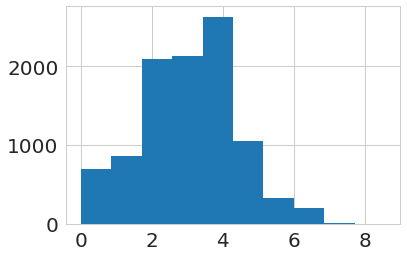

In [171]:
plt.hist(validation_exact_df['frac_interactions_pos_9'].values)

In [172]:
validation_exact_df.head()

,output_pos,output_neg,sequence_length,num_interactions_pos_0,num_interactions_neg_0,num_interactions_pos_1,num_interactions_neg_1,num_interactions_pos_2,num_interactions_neg_2,num_interactions_pos_3,num_interactions_neg_3,num_interactions_pos_4,num_interactions_neg_4,num_interactions_pos_5,num_interactions_neg_5,num_interactions_pos_6,num_interactions_neg_6,num_interactions_pos_7,num_interactions_neg_7,num_interactions_pos_8,num_interactions_neg_8,num_interactions_pos_9,num_interactions_neg_9,frac_interactions_pos_0,frac_interactions_neg_0,frac_interactions_pos_1,frac_interactions_neg_1,frac_interactions_pos_2,frac_interactions_neg_2,frac_interactions_pos_3,frac_interactions_neg_3,frac_interactions_pos_4,frac_interactions_neg_4,frac_interactions_pos_5,frac_interactions_neg_5,frac_interactions_pos_6,frac_interactions_neg_6,frac_interactions_pos_7,frac_interactions_neg_7,frac_interactions_pos_8,frac_interactions_neg_8,frac_interactions_pos_9,frac_interactions_neg_9,sequence_length_bin,frac_interactions_pos_9_bin,frac_interactions_pos_0_bin,frac_interactions_pos_1_bin,frac_interactions_pos_2_bin,frac_interactions_pos_3_bin,frac_interactions_pos_4_bin,frac_interactions_pos_5_bin,frac_interactions_pos_6_bin,frac_interactions_pos_7_bin,frac_interactions_pos_8_bin,frac_interactions_neg_0_bin,frac_interactions_neg_1_bin,frac_interactions_neg_2_bin,frac_interactions_neg_3_bin,frac_interactions_neg_4_bin,frac_interactions_neg_5_bin,frac_interactions_neg_6_bin,frac_interactions_neg_7_bin,frac_interactions_neg_8_bin,frac_interactions_neg_9_bin
0,0.852263,0.176918,123,1061,1165,938,1042,938,1042,938,1042,848,868,772,710,718,582,692,554,670,536,648,518,8.626016,9.471545,7.626016,8.471545,7.626016,8.471545,7.626016,8.471545,6.894309,7.056911,6.276423,5.772358,5.837398,4.731707,5.626016,4.504065,5.447154,4.357724,5.268293,4.211382,100,5,8,7,7,7,6,6,5,5,5,9,8,8,8,7,5,4,4,4,4
1,0.803122,0.097900,263,1883,1959,1620,1696,1620,1696,1620,1696,1370,1464,1132,1258,1022,1144,986,1100,954,1062,932,1036,7.159696,7.448669,6.159696,6.448669,6.159696,6.448669,6.159696,6.448669,5.209125,5.566540,4.304183,4.783270,3.885932,4.349810,3.749049,4.182510,3.627376,4.038023,3.543726,3.939163,250,3,7,6,6,6,5,4,3,3,3,7,6,6,6,5,4,4,4,4,3
2,0.821075,0.427393,107,943,783,836,676,836,676,836,676,686,532,550,402,446,342,430,330,416,316,406,294,8.813084,7.317757,7.813084,6.317757,7.813084,6.317757,7.813084,6.317757,6.411215,4.971963,5.140187,3.757009,4.168224,3.196262,4.018692,3.084112,3.887850,2.953271,3.794393,2.747664,100,3,8,7,7,7,6,5,4,4,3,7,6,6,6,4,3,3,3,2,2
3,0.907894,0.248466,266,1988,2150,1722,1884,1722,1884,1722,1884,1482,1666,1258,1476,1126,1380,1082,1344,1058,1306,1032,1284,7.473684,8.082707,6.473684,7.082707,6.473684,7.082707,6.473684,7.082707,5.571429,6.263158,4.729323,5.548872,4.233083,5.187970,4.067669,5.052632,3.977444,4.909774,3.879699,4.827068,250,3,7,6,6,6,5,4,4,4,3,8,7,7,7,6,5,5,5,4,4
4,0.819187,0.625873,136,876,1226,740,1090,740,1090,740,1090,604,972,478,862,428,782,410,762,398,746,390,728,6.441176,9.014706,5.441176,8.014706,5.441176,8.014706,5.441176,8.014706,4.441176,7.147059,3.514706,6.338235,3.147059,5.750000,3.014706,5.602941,2.926471,5.485294,2.867647,5.352941,100,2,6,5,5,5,4,3,3,3,2,9,8,8,8,7,6,5,5,5,5


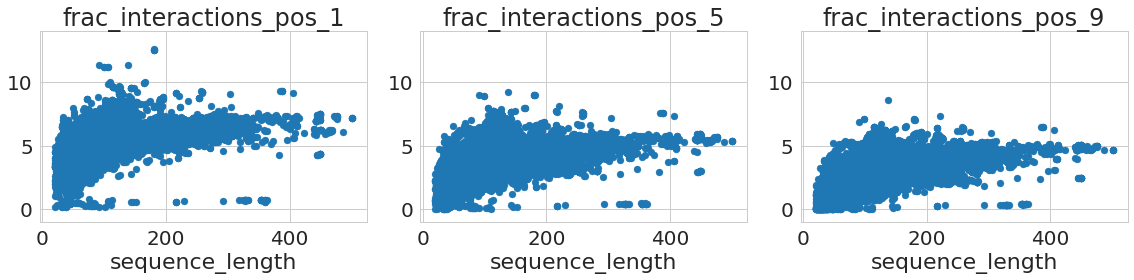

In [174]:
fg, axs = plt.subplots(1, 3, figsize=(16, 4))

plt.axes(axs[0])
feature_columns = 'frac_interactions_pos_1'
plt.scatter(
    validation_exact_df['sequence_length'].values,
    validation_exact_df[feature_columns].values)
plt.xlabel('sequence_length')
plt.title(feature_columns)
plt.ylim(-1, 14)


plt.axes(axs[1])
feature_columns = 'frac_interactions_pos_5'
plt.scatter(
    validation_exact_df['sequence_length'].values,
    validation_exact_df[feature_columns].values)
plt.xlabel('sequence_length')
plt.title(feature_columns)
plt.ylim(-1, 14)


plt.axes(axs[2])
feature_columns = 'frac_interactions_pos_9'
plt.scatter(
    validation_exact_df['sequence_length'].values,
    validation_exact_df[feature_columns].values)
plt.xlabel('sequence_length')
plt.title(feature_columns)
plt.ylim(-1, 14)


plt.tight_layout()

In [82]:
df = validation_exact_df.copy()
df = df[df['sequence_length'] < 500]
df = df.melt(id_vars='sequence_length_bin', value_vars=['output_pos', 'output_neg'])
# df = df.head(10_000)
display(df.head())
Counter(df['variable'])

,sequence_length_bin,variable,value
0,100,output_pos,0.852263
1,250,output_pos,0.803122
2,100,output_pos,0.821075
3,250,output_pos,0.907894
4,100,output_pos,0.819187


Counter({'output_neg': 9996, 'output_pos': 9996})

/home/kimlab1/strokach/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


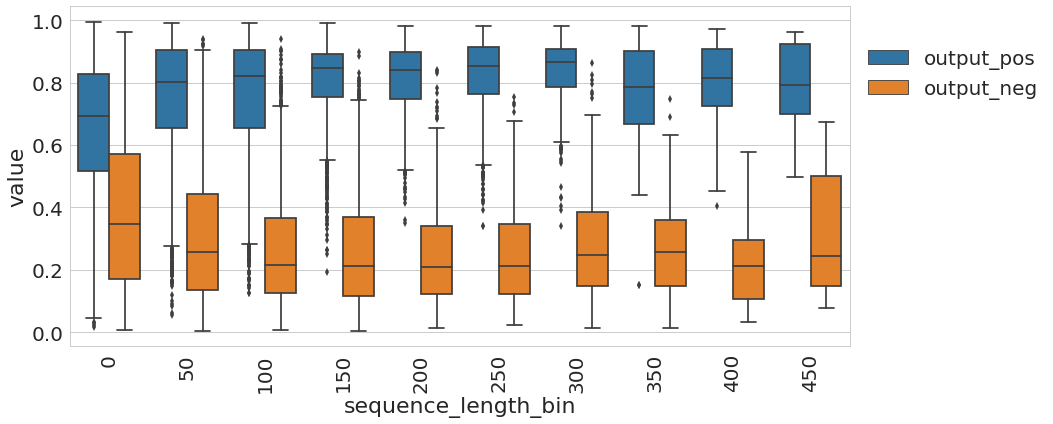

In [147]:
feature_column = 'sequence_length_bin'

# Prepare data
df = validation_exact_df.copy()
df = df[df['sequence_length'] < 500]
df = df.melt(id_vars=feature_column, value_vars=['output_pos', 'output_neg'])

# Plot
fg, ax = plt.subplots(figsize=(12, 6))
ax = sns.boxplot(x=feature_column, y="value", hue='variable', data=df, ax=ax)
# ax = sns.swarmplot(x="sequence_length_bin", y="value", data=df, color=".25")

# Adjust plot
plt.xticks(rotation='vertical')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
# plt.title((feature_column.replace('_', ' ').capitalize())

plt.tight_layout()

/home/kimlab1/strokach/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


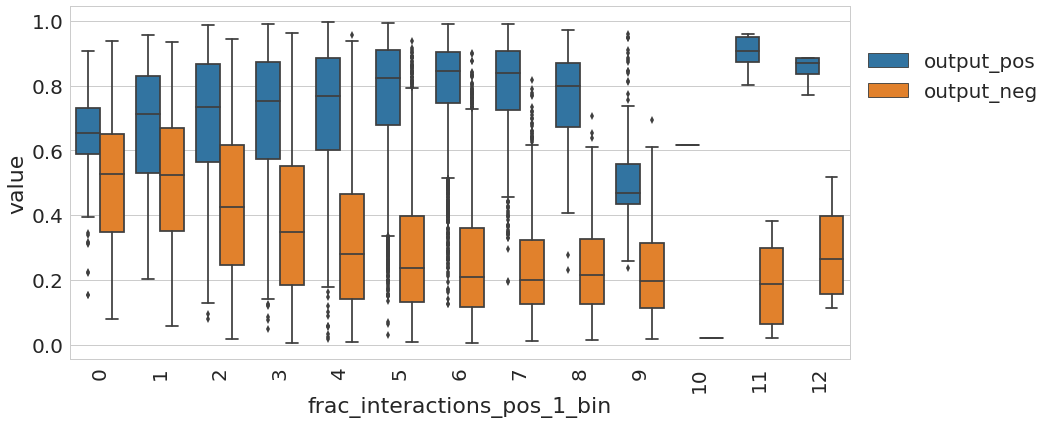

In [130]:
feature_name = 'frac_interactions_pos_1_bin'

# Prepare data
df = validation_exact_df.copy()
df = df[df['sequence_length'] < 500]
df = df.melt(id_vars=feature_name, value_vars=['output_pos'])
df1 = df

# Prepare data
df = validation_exact_df.copy()
df = df[df['sequence_length'] < 500]
df = df.melt(id_vars=feature_name, value_vars=['output_neg'])
df2 = df

df = pd.concat([df1, df2])

# Plot
fg, ax = plt.subplots(figsize=(12, 6))
ax = sns.boxplot(x=feature_name, y="value", hue='variable', data=df, ax=ax)
# ax = sns.swarmplot(x="sequence_length_bin", y="value", data=df, color=".25")

# Adjust plot
plt.xticks(rotation='vertical')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))


plt.tight_layout()

/home/kimlab1/strokach/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


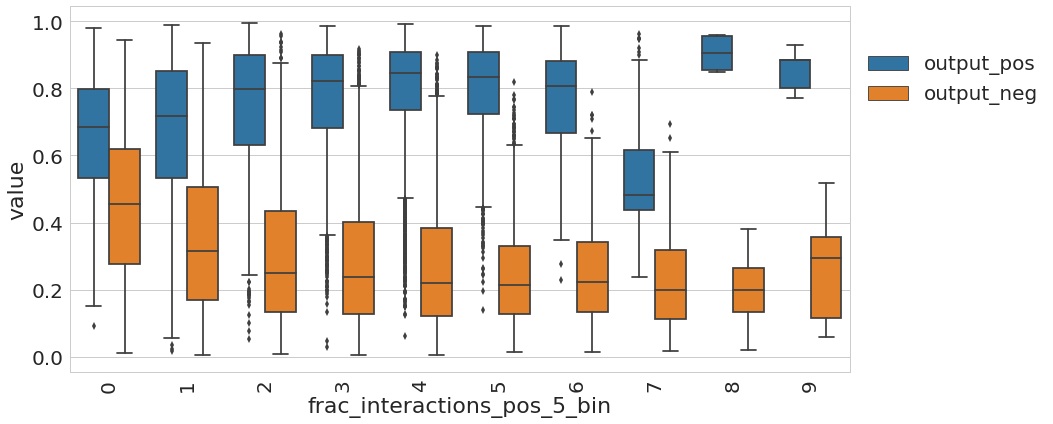

In [134]:
feature_name = 'frac_interactions_pos_5_bin'

# Prepare data
df = validation_exact_df.copy()
df = df[df['sequence_length'] < 500]
df = df.melt(id_vars=feature_name, value_vars=['output_pos'])
df1 = df

# Prepare data
df = validation_exact_df.copy()
df = df[df['sequence_length'] < 500]
df = df.melt(id_vars=feature_name, value_vars=['output_neg'])
df2 = df

df = pd.concat([df1, df2])

# Plot
fg, ax = plt.subplots(figsize=(12, 6))
ax = sns.boxplot(x=feature_name, y="value", hue='variable', data=df, ax=ax)
# ax = sns.swarmplot(x="sequence_length_bin", y="value", data=df, color=".25")

# Adjust plot
plt.xticks(rotation='vertical')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))


plt.tight_layout()

/home/kimlab1/strokach/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


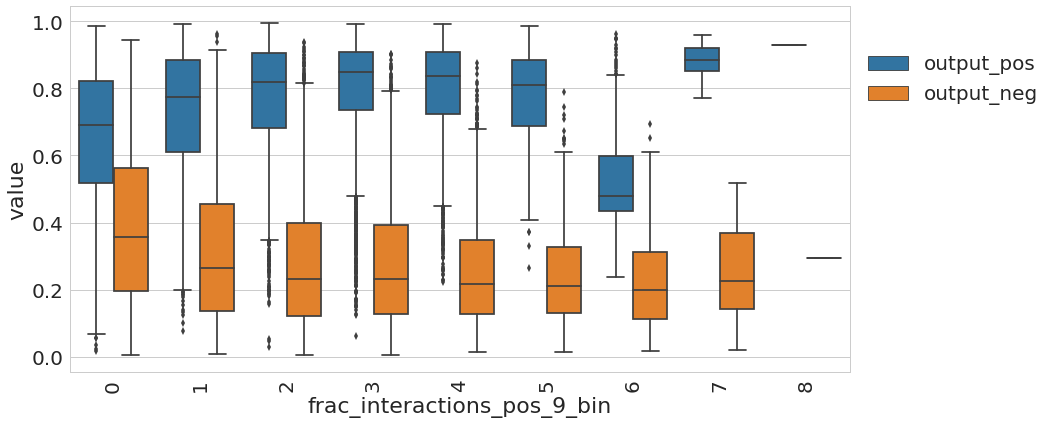

In [135]:
feature_name = 'frac_interactions_pos_9_bin'

# Prepare data
df = validation_exact_df.copy()
df = df[df['sequence_length'] < 500]
df = df.melt(id_vars=feature_name, value_vars=['output_pos'])
df1 = df

# Prepare data
df = validation_exact_df.copy()
df = df[df['sequence_length'] < 500]
df = df.melt(id_vars=feature_name, value_vars=['output_neg'])
df2 = df

df = pd.concat([df1, df2])

# Plot
fg, ax = plt.subplots(figsize=(12, 6))
ax = sns.boxplot(x=feature_name, y="value", hue='variable', data=df, ax=ax)
# ax = sns.swarmplot(x="sequence_length_bin", y="value", data=df, color=".25")

# Adjust plot
plt.xticks(rotation='vertical')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))


plt.tight_layout()